In [1]:
import torch
import wandb
import mylib.utils as utils
from model.resnet4c10q import ResNet20_Q
import matplotlib.pyplot as plt
import numpy as np
from model.q_lib import Conv2d_Q
from mylib.utils import load_CIFAR10

device = 'cpu'

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
def load_wandb_models(wandb_path):
    api = wandb.Api()
    artifact = api.artifact(wandb_path)
    artifact.download(root='./pretrained_model')
    state_dict = torch.load('./pretrained_model/ckpt.pth', map_location=torch.device(device))

    model = ResNet20_Q(a_bit=4, w_bit=2)

    try:
        model.load_state_dict(state_dict['net'])
    except:
        # if the model is wrapped in a module, update all keys in state_dict to remove module.
        state_dict['net'] = {k.replace('module.', ''): v for k, v in state_dict['net'].items()}
        model.load_state_dict(state_dict['net'])

    return model

In [31]:
def nn_traversal(root, layer_name_list, num_row_list, num_zero_list):
    for name, layer in root.named_children():
        if isinstance(layer, Conv2d_Q):
            if layer.in_channels != layer.out_channels:
                continue
            my_tensor = layer.w_q.detach().numpy()
            num_row = utils.rm_algo(my_tensor)
            num_row_list.append(num_row)
            num_zero_list.append(np.sum(my_tensor==0))
            layer_name_list.append(name)
        else:
            if len(layer._modules) == 0:
                continue
            # num_row_list_new, num_zero_list_new, layer_name_list_new = nn_traversal(layer, layer_name_list, num_row_list, num_zero_list)
            num_row_list, num_zero_list, layer_name_list = nn_traversal(layer, layer_name_list, num_row_list, num_zero_list)
            
            # num_row_list.append(num_row_list_new)
            # num_zero_list.append(num_zero_list_new)
            # layer_name_list.append(layer_name_list_new)

    return num_row_list, num_zero_list, layer_name_list

In [37]:
# jke1994/ResNet20_WC/model:v189  :  a_bit=4, w_bit=2, eta=0
# jke1994/ResNet20_WC/model:v182  :  a_bit=4, w_bit=2, eta=100

# jke1994/ResNet20_WC/model:v106  :  a_bit=4, w_bit=4, eta=0
# jke1994/ResNet20_WC/model:v111  :  a_bit=4, w_bit=4, eta=100

model_noWC = load_wandb_models('jke1994/ResNet20_WC/model:v189')
model_WC = load_wandb_models('jke1994/ResNet20_WC/model:v182')
train_loader, test_loader = load_CIFAR10(batch_size=128)

with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs= inputs.to(device)
        outputs = model_noWC(inputs)
        outputs = model_WC(inputs)
        break

wandb:   1 of 1 files downloaded.  
wandb:   1 of 1 files downloaded.  


Files already downloaded and verified
Files already downloaded and verified
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 wi

In [38]:
num_row_list, num_zero_list, layer_name_list = nn_traversal(model_WC, [], [], [])

print(np.sum(num_row_list))
print(np.sum(num_zero_list))
print(num_row_list)


3875
60774
[87, 117, 108, 105, 113, 101, 221, 204, 207, 212, 210, 429, 443, 428, 443, 447]


In [39]:
num_row_list, num_zero_list, layer_name_list = nn_traversal(model_noWC, [], [], [])

print(np.sum(num_row_list))
print(np.sum(num_zero_list))
print(num_row_list)

3688
66788
[83, 69, 78, 111, 107, 95, 207, 203, 204, 219, 219, 424, 412, 410, 434, 413]


In [34]:
104412 - 98988

5424

In [30]:
num_row_list

[144,
 144,
 144,
 144,
 144,
 144,
 288,
 288,
 288,
 288,
 288,
 576,
 576,
 576,
 576,
 576]

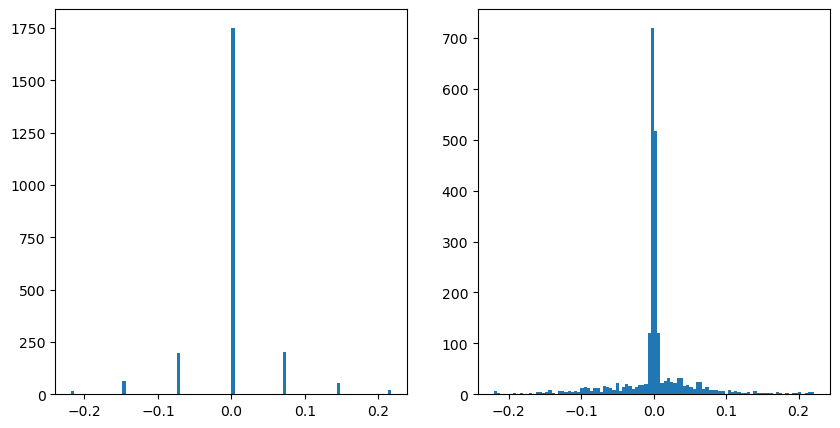

In [12]:
# create a sub figure 1x2
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# plot for the first sub figure
my_tensor = model_WC.layers_2n[0].conv1.w_q.detach().numpy()
axs[0].hist(my_tensor.flatten(), bins=100);

my_tensor = model_WC.layers_2n[0].conv1.weight.detach().numpy()
axs[1].hist(my_tensor.flatten(), bins=100);

In [9]:
with torch.no_grad():
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model_44000(inputs)
        break

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
